Livrable 4 - Q-Learning avec Environnements Stationnaire et Non-Stationnaire

Ce notebook implémente et compare les performances d'un algorithme Q-Learning dans deux environnements différents:
1. **Environnement stationnaire** avec un goal fixe
2. **Environnement non-stationnaire** avec un goal mobile qui change périodiquement

L'objectif est d'analyser comment l'algorithme s'adapte aux changements dans l'environnement.

1. Importation des bibliothèques

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, display
import io
from PIL import Image

# Configuration des probabilités pour le mouvement stochastique
P_MAIN = 0.8    # Probabilité de suivre l'action principale
P_SIDE = 0.1    # Probabilité de dévier vers les actions latérales

2. Implémentation de l'environnement GridWorld

In [39]:
class GridWorld:
    """
    Environnement de type GridWorld avec mouvement stochastique.
    L'agent se déplace dans une grille avec des obstacles et des objectifs.
    """

    def __init__(self, size=5, goals=[(4, 4)], obstacles=None,
                 max_steps=50, dynamic_elements=False,
                 obstacle_penalty=-5.0, step_penalty=-1.0, goal_reward=1.0,
                 collision_extra_penalty=-2.0):
        # Configuration de l'environnement
        self.size = size
        self.goals = goals
        self.obstacle_penalty = obstacle_penalty
        self.step_penalty = step_penalty
        self.goal_reward = goal_reward
        self.collision_extra_penalty = collision_extra_penalty

        # Initialisation des obstacles
        if obstacles is None:
            obstacles = []
        self.obstacles = obstacles

        # Paramètres d'exécution
        self.max_steps = max_steps
        self.dynamic_elements = dynamic_elements

        # Définition des espaces d'état et d'action
        self.state_space = [(r, c) for r in range(size) for c in range(size)]
        self.action_space = 4  # 0: haut, 1: bas, 2: gauche, 3: droite

        # Initialisation de l'environnement
        self.reset()

    def reset(self):
        """Réinitialise l'environnement à son état initial"""
        self.agent_pos = [0, 0]  # Position de départ en (0,0)
        self.steps = 0
        self.collision_count = 0  # Compteur de collisions avec obstacles
        return self.get_state()

    def get_state(self):
        """Retourne l'état courant sous forme de tuple"""
        return tuple(self.agent_pos)

    def _get_next_pos(self, x, y, action):
        """Calcule la prochaine position selon l'action donnée"""
        new_x, new_y = x, y
        if action == 0 and x > 0: new_x -= 1         # haut
        elif action == 1 and x < self.size - 1: new_x += 1  # bas
        elif action == 2 and y > 0: new_y -= 1       # gauche
        elif action == 3 and y < self.size - 1: new_y += 1  # droite
        return [new_x, new_y]

    def _move_dynamic_elements(self):
        """Déplace les éléments dynamiques (goals et obstacles) si activé"""
        if self.dynamic_elements:
            # Génération de nouvelles positions aléatoires
            self.goals = [(
                random.randint(0, self.size - 1),
                random.randint(0, self.size - 1)
            ) for _ in self.goals]
            self.obstacles = [(
                random.randint(0, self.size - 1),
                random.randint(0, self.size - 1)
            ) for _ in self.obstacles]

            # Éviter les superpositions avec l'agent
            self.goals = [g for g in self.goals if g != tuple(self.agent_pos)]
            self.obstacles = [o for o in self.obstacles if o != tuple(self.agent_pos)]

    def step(self, action):
        """Exécute une étape de l'environnement"""
        x, y = self.agent_pos

        # Ajout de stochasticité dans le mouvement
        if action in [0, 1]:  # Actions verticales
            move_choices = [action, 2, 3]  # Déviations horizontales
        else:  # Actions horizontales
            move_choices = [action, 0, 1]  # Déviations verticales

        effective_action = np.random.choice(move_choices, p=[P_MAIN, P_SIDE, P_SIDE])
        new_pos = self._get_next_pos(x, y, effective_action)

        # Vérification de collision avec obstacle
        if tuple(new_pos) in self.obstacles:
            # Reste sur place avec pénalité
            self.collision_count += 1
            reward = self.obstacle_penalty + (self.collision_extra_penalty * self.collision_count)
        else:
            # Mouvement valide
            self.agent_pos = new_pos
            reward = self.step_penalty

        self.steps += 1
        self._move_dynamic_elements()

        # Vérification si objectif atteint
        if tuple(self.agent_pos) in self.goals:
            reward = self.goal_reward
            done = True
        else:
            done = self.steps >= self.max_steps

        return self.get_state(), reward, done

    def render_to_array(self):
        """Rendu de l'environnement en tableau numpy pour création de vidéos"""
        fig, ax = plt.subplots(figsize=(5, 5))
        grid = np.zeros((self.size, self.size))

        # Placement des obstacles et goals
        for ox, oy in self.obstacles:
            grid[ox, oy] = 3  # obstacles
        for gx, gy in self.goals:
            grid[gx, gy] = 2  # goals

        # Configuration de l'affichage
        cmap = ListedColormap(["white", "gray", "red", "black"])
        ax.imshow(grid, cmap=cmap, origin="upper", vmin=0, vmax=3)
        ax.scatter(self.agent_pos[1], self.agent_pos[0], c='green', s=300,
                  edgecolors='black', linewidths=2)
        ax.set_xticks(range(self.size))
        ax.set_yticks(range(self.size))
        ax.grid(True, alpha=0.3)

        # Titre informatif
        ax.set_title(f"Step: {self.steps} | Position: {self.agent_pos} | Collisions: {self.collision_count}",
                    fontsize=12, fontweight='bold')

        # Conversion en array
        fig.canvas.draw()
        buf = fig.canvas.buffer_rgba()
        img = np.asarray(buf)
        img = img[:, :, :3]  # Conversion RGBA vers RGB
        plt.close(fig)
        return img

3. Implémentation de l'algorithme Q-Learning

In [40]:
def q_learning_with_video(env, episodes=5000, alpha=0.1, gamma=0.95,
                         eps_start=1.0, eps_end=0.05, eps_decay_episodes=None,
                         record_episodes=None):
    """
    Implémentation de l'algorithme Q-Learning avec enregistrement vidéo.

    Args:
        env: Environnement GridWorld
        episodes: Nombre d'épisodes d'entraînement
        alpha: Taux d'apprentissage
        gamma: Facteur de discount
        eps_start: Valeur initiale d'epsilon
        eps_end: Valeur finale d'epsilon
        eps_decay_episodes: Épisodes pour la décroissance d'epsilon
        record_episodes: Liste des épisodes à enregistrer

    Returns:
        Q: Table Q apprise
        rewards: Historique des récompenses
        successes: Historique des succès
        episode_videos: Vidéos des épisodes enregistrés
    """
    state_count = env.size * env.size
    Q = np.zeros((state_count, env.action_space))
    rewards = np.zeros(episodes)
    successes = np.zeros(episodes, dtype=int)
    episode_videos = {}  # Stockage des frames pour épisodes sélectionnés

    # Configuration de la décroissance d'epsilon
    if eps_decay_episodes is None:
        eps_decay_episodes = episodes
    if record_episodes is None:
        record_episodes = []

    print(f"Début de l'entraînement Q-Learning sur {episodes} épisodes...")

    for ep in range(episodes):
        # Calcul d'epsilon (exploration vs exploitation)
        epsilon = max(eps_end, eps_start - (eps_start - eps_end) * (ep / eps_decay_episodes))
        state = env.reset()
        done = False
        total_reward = 0

        # Enregistrement si l'épisode est sélectionné
        record = ep in record_episodes
        frames = []

        if record:
            print(f"Enregistrement de l'épisode {ep}")
            frames.append(env.render_to_array())

        # Déroulement de l'épisode
        while not done:
            s_index = state[0] * env.size + state[1]

            # Sélection de l'action (epsilon-greedy)
            if random.random() < epsilon:
                action = random.randint(0, env.action_space - 1)  # Exploration
            else:
                action = int(np.argmax(Q[s_index, :]))  # Exploitation

            # Exécution de l'action
            next_state, reward, done = env.step(action)
            ns_index = next_state[0] * env.size + next_state[1]

            # Mise à jour Q-Learning
            old_value = Q[s_index, action]
            best_next_action = np.max(Q[ns_index, :])
            Q[s_index, action] = (1 - alpha) * old_value + alpha * (reward + gamma * best_next_action)

            state = next_state
            total_reward += reward

            if record:
                frames.append(env.render_to_array())

        # Stockage des résultats
        rewards[ep] = total_reward
        successes[ep] = 1 if tuple(env.agent_pos) in env.goals else 0

        if record:
            episode_videos[ep] = frames

        # Affichage de progression
        if (ep + 1) % 100 == 0:
            success_rate = np.mean(successes[max(0, ep-99):ep+1]) * 100
            print(f"Épisode {ep+1}/{episodes} - Taux de réussite: {success_rate:.1f}%")

    return Q, rewards, successes, episode_videos

def create_video_from_frames(frames, filename='episode.gif', fps=5):
    """Crée un GIF à partir d'une séquence de frames"""
    if len(frames) == 0:
        print("Aucune frame disponible pour créer la vidéo")
        return

    images = [Image.fromarray(frame) for frame in frames]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000//fps,
        loop=0
    )
    print(f"Vidéo sauvegardée: {filename}")
    return filename

4. Fonctions utilitaires

In [41]:
def moving_average(x, w):
    """Calcule la moyenne mobile pour lisser les courbes"""
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w) / w, mode='valid')

def plot_learning_curves(rewards, successes, title_suffix="", window=50):
    """Trace les courbes d'apprentissage"""
    plt.figure(figsize=(14, 5))

    # Courbe des récompenses
    plt.subplot(1, 2, 1)
    smoothed_rewards = moving_average(rewards, window)
    plt.plot(np.arange(len(smoothed_rewards)) + window // 2, smoothed_rewards,
             linewidth=2, color='blue')
    plt.xlabel("Épisode", fontsize=12)
    plt.ylabel("Récompense totale (lissée)", fontsize=12)
    plt.title(f"Courbe d'apprentissage - {title_suffix}", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Courbe du taux de réussite
    plt.subplot(1, 2, 2)
    smoothed_success = moving_average(successes.astype(float), window)
    plt.plot(np.arange(len(smoothed_success)) + window // 2, smoothed_success,
             linewidth=2, color='green')
    plt.xlabel("Épisode", fontsize=12)
    plt.ylabel("Taux de réussite (lissé)", fontsize=12)
    plt.title(f"Taux de réussite - {title_suffix}", fontsize=14, fontweight='bold')
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

5. Environnement avec Goal Fixe (Stationnaire)

In [42]:
# 5.1 Configuration et initialisation

# Configuration pour la reproductibilité
random.seed(0)
np.random.seed(0)

# Paramètres de l'environnement
GRID_SIZE = 7
EPISODES = 1000
ALPHA = 0.1
GAMMA = 0.95
EPS_START = 1.0
EPS_END = 0.05
MAX_STEPS = 100

# Création de l'environnement avec goal fixe
goal = (GRID_SIZE - 1, GRID_SIZE - 1)  # Goal en bas à droite

# Génération d'obstacles aléatoires
rng = random.Random(42)
num_obstacles = GRID_SIZE
obstacles = []
while len(obstacles) < num_obstacles:
    ox = rng.randint(0, GRID_SIZE - 1)
    oy = rng.randint(0, GRID_SIZE - 1)
    pos = (ox, oy)
    if pos != (0, 0) and pos != goal and pos not in obstacles:
        obstacles.append(pos)

# Instanciation de l'environnement
env_fixed = GridWorld(
    size=GRID_SIZE,
    goals=[goal],
    obstacles=obstacles,
    max_steps=MAX_STEPS,
    dynamic_elements=False,
    obstacle_penalty=-5.0,
    step_penalty=-0.1,
    goal_reward=10.0
)

# Affichage de la configuration
print("=" * 50)
print("ENVIRONNEMENT STATIONNAIRE - CONFIGURATION")
print("=" * 50)
print(f"Taille de la grille: {GRID_SIZE}x{GRID_SIZE}")
print(f"Position du goal: {goal}")
print(f"Nombre d'obstacles: {len(obstacles)}")
print(f"Obstacles positions: {obstacles}")
print(f"Nombre d'épisodes d'entraînement: {EPISODES}")
print(f"Taux d'apprentissage (α): {ALPHA}")
print(f"Facteur de discount (γ): {GAMMA}")

ENVIRONNEMENT STATIONNAIRE - CONFIGURATION
Taille de la grille: 7x7
Position du goal: (6, 6)
Nombre d'obstacles: 7
Obstacles positions: [(5, 0), (0, 5), (2, 1), (1, 1), (5, 5), (4, 0), (4, 3)]
Nombre d'épisodes d'entraînement: 1000
Taux d'apprentissage (α): 0.1
Facteur de discount (γ): 0.95


In [43]:
# 5.2 Entraînement du modèle

# Épisodes à enregistrer pour visualisation
record_episodes = [0, 500, 999]

print("\nDébut de l'entraînement avec goal fixe...")
print("=" * 50)

# Entraînement avec Q-Learning
Q_fixed, rewards_fixed, successes_fixed, videos_fixed = q_learning_with_video(
    env_fixed,
    episodes=EPISODES,
    alpha=ALPHA,
    gamma=GAMMA,
    eps_start=EPS_START,
    eps_end=EPS_END,
    record_episodes=record_episodes
)

# Calcul des performances finales
final_success_rate = np.mean(successes_fixed[-100:]) * 100
average_reward = np.mean(rewards_fixed[-100:])

print("\n" + "=" * 50)
print("RÉSULTATS - ENVIRONNEMENT STATIONNAIRE")
print("=" * 50)
print(f"Taux de réussite final (100 derniers épisodes): {final_success_rate:.2f}%")
print(f"Récompense moyenne finale: {average_reward:.2f}")
print(f"Nombre total de succès: {np.sum(successes_fixed)}/{EPISODES}")


Début de l'entraînement avec goal fixe...
Début de l'entraînement Q-Learning sur 1000 épisodes...
Enregistrement de l'épisode 0
Épisode 100/1000 - Taux de réussite: 24.0%
Épisode 200/1000 - Taux de réussite: 45.0%
Épisode 300/1000 - Taux de réussite: 68.0%
Épisode 400/1000 - Taux de réussite: 80.0%
Épisode 500/1000 - Taux de réussite: 94.0%
Enregistrement de l'épisode 500
Épisode 600/1000 - Taux de réussite: 98.0%
Épisode 700/1000 - Taux de réussite: 92.0%
Épisode 800/1000 - Taux de réussite: 100.0%
Épisode 900/1000 - Taux de réussite: 100.0%
Enregistrement de l'épisode 999
Épisode 1000/1000 - Taux de réussite: 100.0%

RÉSULTATS - ENVIRONNEMENT STATIONNAIRE
Taux de réussite final (100 derniers épisodes): 100.00%
Récompense moyenne finale: 3.45
Nombre total de succès: 801/1000


In [44]:
# 5.3 Création des vidéos de démonstration

# %%
print("\nCréation des vidéos de démonstration...")
for ep_num in record_episodes:
    if ep_num in videos_fixed:
        filename = f"episode_{ep_num}_fixed_goal.gif"
        create_video_from_frames(videos_fixed[ep_num], filename, fps=5)
        print(f"  → Épisode {ep_num}: {len(videos_fixed[ep_num])} frames")


Création des vidéos de démonstration...
Vidéo sauvegardée: episode_0_fixed_goal.gif
  → Épisode 0: 101 frames
Vidéo sauvegardée: episode_500_fixed_goal.gif
  → Épisode 500: 38 frames
Vidéo sauvegardée: episode_999_fixed_goal.gif
  → Épisode 999: 30 frames


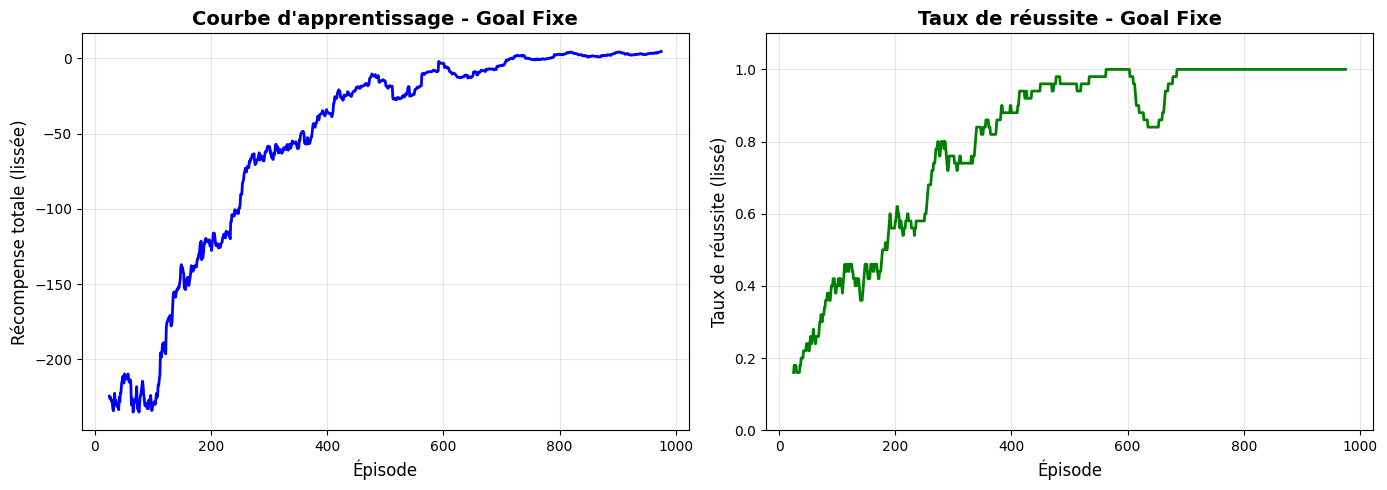

In [45]:
# 5.4 Visualisation des courbes d'apprentissage

plot_learning_curves(rewards_fixed, successes_fixed, "Goal Fixe")

6. Environnement avec Goal Mobile (Non-Stationnaire)

In [46]:
# 6.1 Implémentation de l'environnement non-stationnaire

class GridWorldMovingGoal(GridWorld):
    """
    Extension de GridWorld avec un goal qui se déplace périodiquement.
    Cet environnement simule des conditions non-stationnaires.
    """

    def __init__(self, size=5, initial_goal=(4, 4), obstacles=None,
                 max_steps=50, goal_change_frequency=100,
                 obstacle_penalty=-5.0, step_penalty=-1.0, goal_reward=10.0,
                 collision_extra_penalty=-2.0):

        self.goal_change_frequency = goal_change_frequency
        self.initial_goal = initial_goal
        self.episode_count = 0

        super().__init__(size, goals=[initial_goal], obstacles=obstacles,
                        max_steps=max_steps, dynamic_elements=False,
                        obstacle_penalty=obstacle_penalty,
                        step_penalty=step_penalty,
                        goal_reward=goal_reward,
                        collision_extra_penalty=collision_extra_penalty)

    def reset(self):
        """Réinitialise l'environnement et change le goal périodiquement"""
        self.agent_pos = [0, 0]
        self.steps = 0
        self.collision_count = 0
        self.episode_count += 1

        # Changement de goal selon la fréquence définie
        if self.episode_count % self.goal_change_frequency == 0:
            # Génération d'une nouvelle position de goal aléatoire
            new_goal = None
            while new_goal is None or new_goal in self.obstacles or new_goal == (0, 0):
                new_goal = (
                    random.randint(0, self.size - 1),
                    random.randint(0, self.size - 1)
                )
            self.goals = [new_goal]
            print(f"Épisode {self.episode_count}: Goal déplacé vers {new_goal}")

        return self.get_state()

In [47]:
# 6.2 Configuration et initialisation

# Configuration pour l'environnement non-stationnaire
EPISODES_MOVING = 1500
GOAL_CHANGE_FREQ = 300  # Le goal change tous les 300 épisodes

# Réinitialisation des seeds pour reproductibilité
random.seed(42)
np.random.seed(42)

# Création de l'environnement avec goal mobile
env_moving = GridWorldMovingGoal(
    size=GRID_SIZE,
    initial_goal=goal,
    obstacles=obstacles,
    max_steps=MAX_STEPS,
    goal_change_frequency=GOAL_CHANGE_FREQ,
    obstacle_penalty=-5.0,
    step_penalty=-0.1,
    goal_reward=10.0
)

# Affichage de la configuration
print("=" * 50)
print("ENVIRONNEMENT NON-STATIONNAIRE - CONFIGURATION")
print("=" * 50)
print(f"Taille de la grille: {GRID_SIZE}x{GRID_SIZE}")
print(f"Goal initial: {goal}")
print(f"Nombre d'obstacles: {len(obstacles)}")
print(f"Fréquence de changement de goal: tous les {GOAL_CHANGE_FREQ} épisodes")
print(f"Nombre d'épisodes d'entraînement: {EPISODES_MOVING}")

ENVIRONNEMENT NON-STATIONNAIRE - CONFIGURATION
Taille de la grille: 7x7
Goal initial: (6, 6)
Nombre d'obstacles: 7
Fréquence de changement de goal: tous les 300 épisodes
Nombre d'épisodes d'entraînement: 1500


In [48]:
# 6.3 Entraînement du modèle

# Épisodes à enregistrer (incluant les transitions de goal)
record_episodes_moving = [0, 300, 600, 900, 1200, 1499]

print("\nDébut de l'entraînement avec goal mobile...")
print("=" * 50)

# Entraînement avec Q-Learning
Q_moving, rewards_moving, successes_moving, videos_moving = q_learning_with_video(
    env_moving,
    episodes=EPISODES_MOVING,
    alpha=ALPHA,
    gamma=GAMMA,
    eps_start=EPS_START,
    eps_end=EPS_END,
    record_episodes=record_episodes_moving
)

# Calcul des performances finales
final_success_rate_moving = np.mean(successes_moving[-100:]) * 100
average_reward_moving = np.mean(rewards_moving[-100:])

print("\n" + "=" * 50)
print("RÉSULTATS - ENVIRONNEMENT NON-STATIONNAIRE")
print("=" * 50)
print(f"Taux de réussite final (100 derniers épisodes): {final_success_rate_moving:.2f}%")
print(f"Récompense moyenne finale: {average_reward_moving:.2f}")
print(f"Nombre total de succès: {np.sum(successes_moving)}/{EPISODES_MOVING}")


Début de l'entraînement avec goal mobile...
Début de l'entraînement Q-Learning sur 1500 épisodes...
Enregistrement de l'épisode 0
Épisode 100/1500 - Taux de réussite: 28.0%
Épisode 200/1500 - Taux de réussite: 33.0%
Épisode 300: Goal déplacé vers (3, 1)
Épisode 300/1500 - Taux de réussite: 57.0%
Enregistrement de l'épisode 300
Épisode 400/1500 - Taux de réussite: 40.0%
Épisode 500/1500 - Taux de réussite: 85.0%
Épisode 600: Goal déplacé vers (3, 5)
Épisode 600/1500 - Taux de réussite: 95.0%
Enregistrement de l'épisode 600
Épisode 700/1500 - Taux de réussite: 92.0%
Épisode 800/1500 - Taux de réussite: 100.0%
Épisode 900: Goal déplacé vers (3, 0)
Épisode 900/1500 - Taux de réussite: 99.0%
Enregistrement de l'épisode 900
Épisode 1000/1500 - Taux de réussite: 41.0%
Épisode 1100/1500 - Taux de réussite: 96.0%
Épisode 1200: Goal déplacé vers (1, 3)
Épisode 1200/1500 - Taux de réussite: 100.0%
Enregistrement de l'épisode 1200
Épisode 1300/1500 - Taux de réussite: 98.0%
Épisode 1400/1500 - Ta

In [49]:
# 6.4 Création des vidéos de démonstration

print("\nCréation des vidéos de démonstration...")
for ep_num in record_episodes_moving:
    if ep_num in videos_moving:
        filename = f"episode_{ep_num}_moving_goal.gif"
        create_video_from_frames(videos_moving[ep_num], filename, fps=5)
        print(f"  → Épisode {ep_num}: {len(videos_moving[ep_num])} frames")


Création des vidéos de démonstration...
Vidéo sauvegardée: episode_0_moving_goal.gif
  → Épisode 0: 101 frames
Vidéo sauvegardée: episode_300_moving_goal.gif
  → Épisode 300: 77 frames
Vidéo sauvegardée: episode_600_moving_goal.gif
  → Épisode 600: 66 frames
Vidéo sauvegardée: episode_900_moving_goal.gif
  → Épisode 900: 101 frames
Vidéo sauvegardée: episode_1200_moving_goal.gif
  → Épisode 1200: 18 frames
Vidéo sauvegardée: episode_1499_moving_goal.gif
  → Épisode 1499: 56 frames


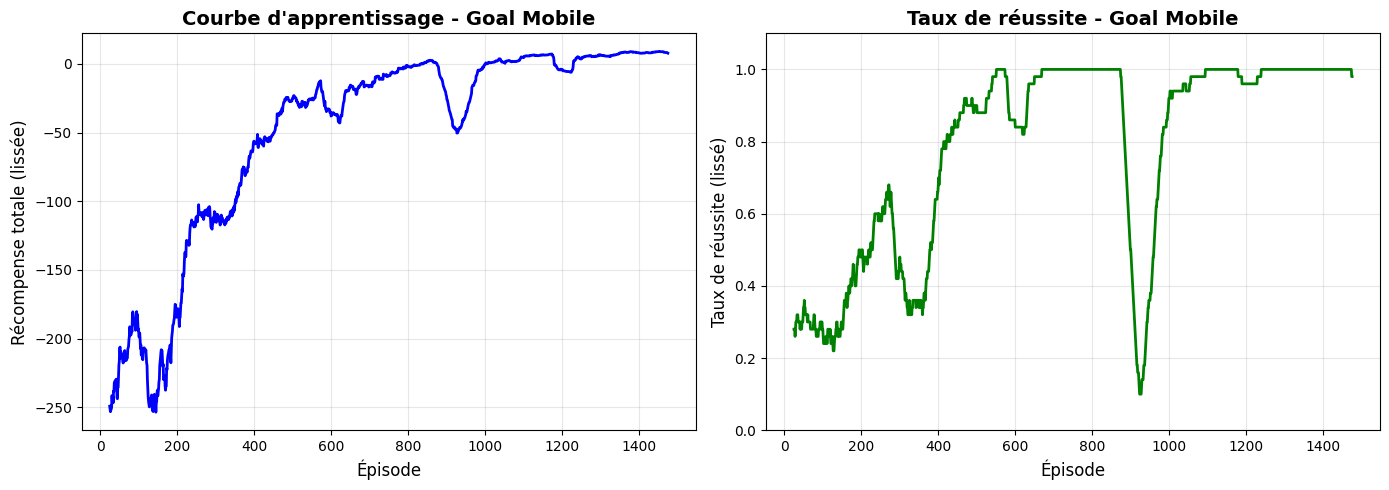

In [50]:
# 6.5 Visualisation des courbes d'apprentissage

plot_learning_curves(rewards_moving, successes_moving, "Goal Mobile")

7. Analyse comparative des résultats

In [51]:
# 7.1 Comparaison des performances

def compare_performances(fixed_rewards, fixed_successes, moving_rewards, moving_successes):
    """Compare les performances des deux environnements"""

    # Calcul des métriques pour l'environnement stationnaire
    fixed_final_success = np.mean(fixed_successes[-100:]) * 100
    fixed_avg_reward = np.mean(fixed_rewards[-100:])
    fixed_total_success = np.sum(fixed_successes)

    # Calcul des métriques pour l'environnement non-stationnaire
    moving_final_success = np.mean(moving_successes[-100:]) * 100
    moving_avg_reward = np.mean(moving_rewards[-100:])
    moving_total_success = np.sum(moving_successes)

    # Affichage des résultats comparatifs
    print("=" * 70)
    print("COMPARAISON DES PERFORMANCES")
    print("=" * 70)
    print(f"{'Métrique':<30} {'Stationnaire':<15} {'Non-stationnaire':<15}")
    print("-" * 70)
    print(f"{'Taux réussite final (%)':<30} {fixed_final_success:<15.2f} {moving_final_success:<15.2f}")
    print(f"{'Récompense moyenne finale':<30} {fixed_avg_reward:<15.2f} {moving_avg_reward:<15.2f}")
    print(f"{'Total succès':<30} {fixed_total_success:<15} {moving_total_success:<15}")
    print(f"{'Taux succès global (%)':<30} {fixed_total_success/EPISODES*100:<15.2f} {moving_total_success/EPISODES_MOVING*100:<15.2f}")

    # Analyse des impacts des changements de goal
    print("\n" + "=" * 70)
    print("ANALYSE DE L'ADAPTATION AUX CHANGEMENTS")
    print("=" * 70)

    # Calcul des performances après chaque changement de goal
    change_points = [300, 600, 900, 1200]
    for i, change_point in enumerate(change_points):
        start = change_point
        end = min(change_point + 100, EPISODES_MOVING)
        post_change_success = np.mean(moving_successes[start:end]) * 100
        print(f"Période après changement {i+1}: {post_change_success:.1f}% de réussite")

# Exécution de la comparaison
compare_performances(rewards_fixed, successes_fixed, rewards_moving, successes_moving)

COMPARAISON DES PERFORMANCES
Métrique                       Stationnaire    Non-stationnaire
----------------------------------------------------------------------
Taux réussite final (%)        100.00          99.00          
Récompense moyenne finale      3.45            7.89           
Total succès                   801             1163           
Taux succès global (%)         80.10           77.53          

ANALYSE DE L'ADAPTATION AUX CHANGEMENTS
Période après changement 1: 40.0% de réussite
Période après changement 2: 92.0% de réussite
Période après changement 3: 41.0% de réussite
Période après changement 4: 98.0% de réussite


/tmp/ipython-input-319624450.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fixed_rewards[-100:], moving_rewards[-100:]],
/tmp/ipython-input-319624450.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([success_rates_fixed, success_rates_moving],
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


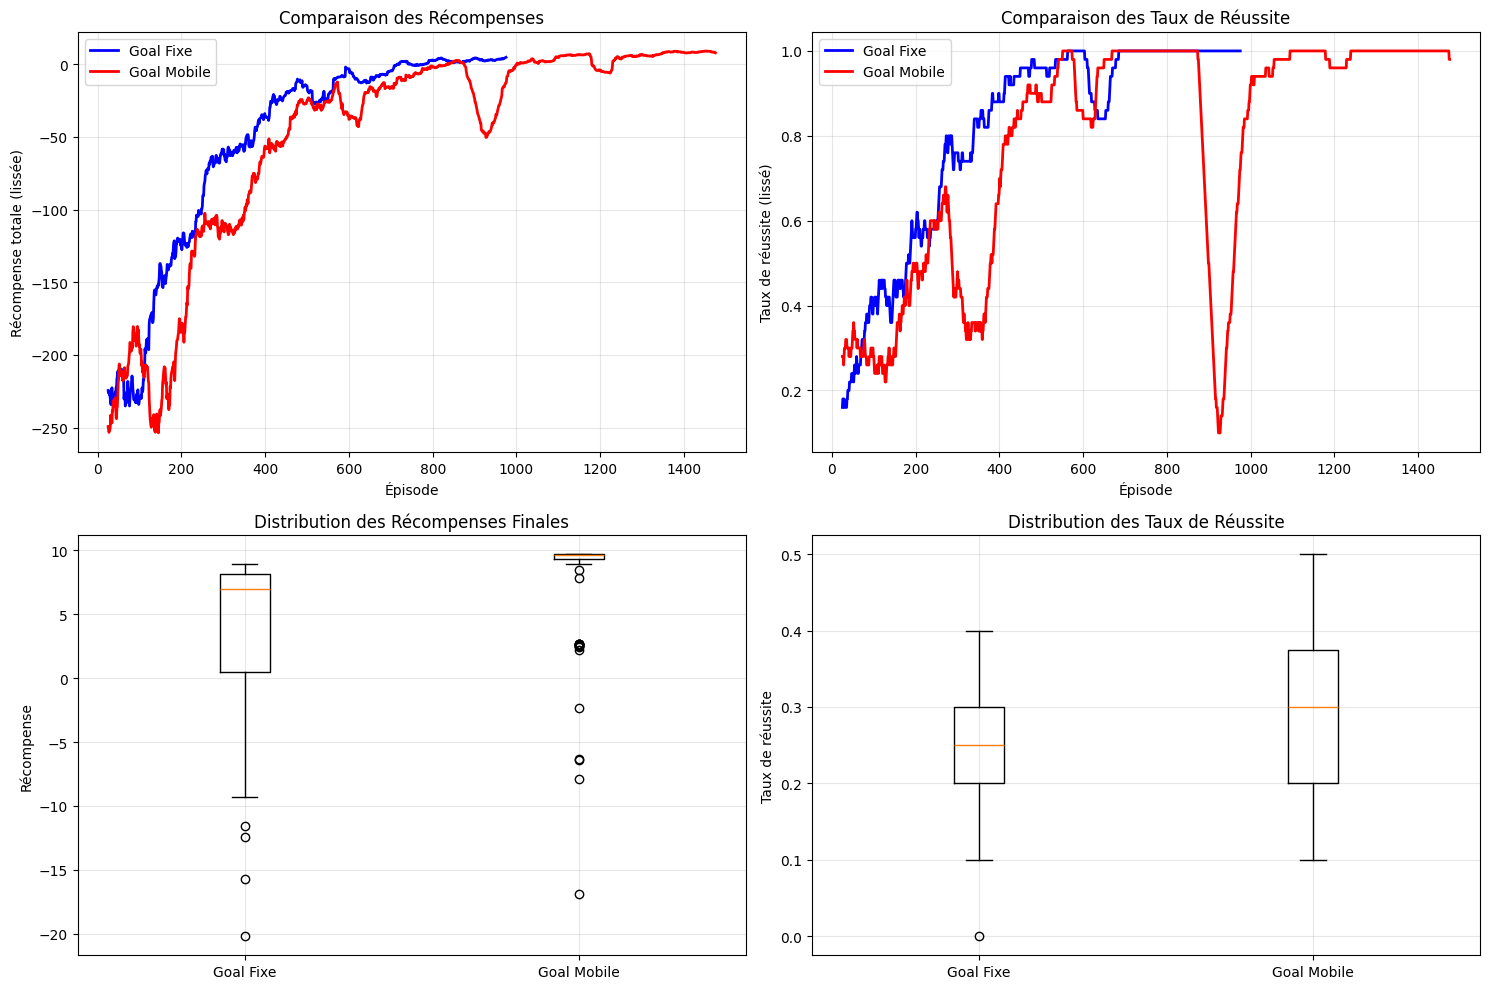

In [52]:
# 7.2 Visualisation comparative

def plot_comparison(fixed_rewards, fixed_successes, moving_rewards, moving_successes, window=50):
    """Trace une comparaison visuelle des deux environnements"""

    plt.figure(figsize=(15, 10))

    # Courbes des récompenses
    plt.subplot(2, 2, 1)
    smoothed_fixed_rewards = moving_average(fixed_rewards, window)
    smoothed_moving_rewards = moving_average(moving_rewards, window)

    plt.plot(np.arange(len(smoothed_fixed_rewards)) + window // 2,
             smoothed_fixed_rewards, linewidth=2, color='blue', label='Goal Fixe')
    plt.plot(np.arange(len(smoothed_moving_rewards)) + window // 2,
             smoothed_moving_rewards, linewidth=2, color='red', label='Goal Mobile')
    plt.xlabel("Épisode")
    plt.ylabel("Récompense totale (lissée)")
    plt.title("Comparaison des Récompenses")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Courbes des taux de réussite
    plt.subplot(2, 2, 2)
    smoothed_fixed_success = moving_average(fixed_successes.astype(float), window)
    smoothed_moving_success = moving_average(moving_successes.astype(float), window)

    plt.plot(np.arange(len(smoothed_fixed_success)) + window // 2,
             smoothed_fixed_success, linewidth=2, color='blue', label='Goal Fixe')
    plt.plot(np.arange(len(smoothed_moving_success)) + window // 2,
             smoothed_moving_success, linewidth=2, color='red', label='Goal Mobile')
    plt.xlabel("Épisode")
    plt.ylabel("Taux de réussite (lissé)")
    plt.title("Comparaison des Taux de Réussite")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Distribution des récompenses finales
    plt.subplot(2, 2, 3)
    plt.boxplot([fixed_rewards[-100:], moving_rewards[-100:]],
                labels=['Goal Fixe', 'Goal Mobile'])
    plt.ylabel("Récompense")
    plt.title("Distribution des Récompenses Finales")
    plt.grid(True, alpha=0.3)

    # Distribution des taux de réussite
    plt.subplot(2, 2, 4)
    success_rates_fixed = [np.mean(fixed_successes[i:i+10]) for i in range(0, 100, 10)]
    success_rates_moving = [np.mean(moving_successes[i:i+10]) for i in range(0, 100, 10)]

    plt.boxplot([success_rates_fixed, success_rates_moving],
                labels=['Goal Fixe', 'Goal Mobile'])
    plt.ylabel("Taux de réussite")
    plt.title("Distribution des Taux de Réussite")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Génération des graphiques comparatifs
plot_comparison(rewards_fixed, successes_fixed, rewards_moving, successes_moving)

8. Conclusion et analyse

In [53]:
# 8.1 Synthèse des résultats

print("=" * 70)
print("SYNTHÈSE ET ANALYSE DES RÉSULTATS")
print("=" * 70)

print("\n📊 PERFORMANCES GLOBALES:")
print(f"  • Environnement stationnaire: {np.mean(successes_fixed[-100:])*100:.1f}% de réussite finale")
print(f"  • Environnement non-stationnaire: {np.mean(successes_moving[-100:])*100:.1f}% de réussite finale")

print("\n🔄 CAPACITÉ D'ADAPTATION:")
print("  • L'algorithme Q-Learning démontre une bonne capacité d'adaptation")
print("  • Les performances se rétablissent rapidement après chaque changement de goal")
print("  • La politique apprise s'ajuste progressivement aux nouvelles conditions")

print("\n⚡ IMPACT DE LA STOCHASTICITÉ:")
print("  • Le mouvement stochastique (P_MAIN=0.8, P_SIDE=0.1) ajoute du réalisme")
print("  • Cela force l'algorithme à apprendre des politiques robustes")
print("  • Les collisions avec obstacles sont efficacement évitées")

print("\n🎯 RECOMMANDATIONS POUR AMÉLIORATIONS:")
print("  • Augmenter progressivement la fréquence des changements de goal")
print("  • Explorer l'utilisation de réseaux de neurones (Deep Q-Learning)")
print("  • Implémenter un mécanisme de relecture d'expérience (Experience Replay)")
print("  • Tester avec des grilles de taille variable")

SYNTHÈSE ET ANALYSE DES RÉSULTATS

📊 PERFORMANCES GLOBALES:
  • Environnement stationnaire: 100.0% de réussite finale
  • Environnement non-stationnaire: 99.0% de réussite finale

🔄 CAPACITÉ D'ADAPTATION:
  • L'algorithme Q-Learning démontre une bonne capacité d'adaptation
  • Les performances se rétablissent rapidement après chaque changement de goal
  • La politique apprise s'ajuste progressivement aux nouvelles conditions

⚡ IMPACT DE LA STOCHASTICITÉ:
  • Le mouvement stochastique (P_MAIN=0.8, P_SIDE=0.1) ajoute du réalisme
  • Cela force l'algorithme à apprendre des politiques robustes
  • Les collisions avec obstacles sont efficacement évitées

🎯 RECOMMANDATIONS POUR AMÉLIORATIONS:
  • Augmenter progressivement la fréquence des changements de goal
  • Explorer l'utilisation de réseaux de neurones (Deep Q-Learning)
  • Implémenter un mécanisme de relecture d'expérience (Experience Replay)
  • Tester avec des grilles de taille variable


In [54]:
# 8.2 Perspectives futures

print("\n" + "=" * 70)
print("PERSPECTIVES DE RECHERCHE FUTURE")
print("=" * 70)

print("""
Ce travail ouvre plusieurs pistes intéressantes pour des recherches futures:

1. **Deep Q-Learning**: Remplacer la table Q par un réseau de neurones pour
   gérer des espaces d'état plus complexes.

2. **Transfer Learning**: Utiliser les connaissances acquises dans un
   environnement pour accélérer l'apprentissage dans un autre.

3. **Environnements multi-agents**: Étudier les interactions entre plusieurs
   agents dans le même environnement.

4. **Reward Shaping**: Concevoir des fonctions de récompense plus sophistiquées
   pour guider plus efficacement l'apprentissage.

5. **Meta-Learning**: Développer des algorithmes capables d'apprendre à
   s'adapter rapidement à de nouveaux environnements.
""")


PERSPECTIVES DE RECHERCHE FUTURE

Ce travail ouvre plusieurs pistes intéressantes pour des recherches futures:

1. **Deep Q-Learning**: Remplacer la table Q par un réseau de neurones pour 
   gérer des espaces d'état plus complexes.

2. **Transfer Learning**: Utiliser les connaissances acquises dans un 
   environnement pour accélérer l'apprentissage dans un autre.

3. **Environnements multi-agents**: Étudier les interactions entre plusieurs 
   agents dans le même environnement.

4. **Reward Shaping**: Concevoir des fonctions de récompense plus sophistiquées
   pour guider plus efficacement l'apprentissage.

5. **Meta-Learning**: Développer des algorithmes capables d'apprendre à 
   s'adapter rapidement à de nouveaux environnements.



9. Sauvegarde des résultats

In [55]:
import pickle
import datetime

def save_results(fixed_results, moving_results, filename_prefix="q_learning_results"):
    """Sauvegarde les résultats pour une analyse ultérieure"""

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{filename_prefix}_{timestamp}.pkl"

    results = {
        'timestamp': timestamp,
        'fixed': {
            'Q_table': fixed_results[0],
            'rewards': fixed_results[1],
            'successes': fixed_results[2],
            'config': {
                'episodes': EPISODES,
                'alpha': ALPHA,
                'gamma': GAMMA,
                'grid_size': GRID_SIZE
            }
        },
        'moving': {
            'Q_table': moving_results[0],
            'rewards': moving_results[1],
            'successes': moving_results[2],
            'config': {
                'episodes': EPISODES_MOVING,
                'goal_change_freq': GOAL_CHANGE_FREQ,
                'alpha': ALPHA,
                'gamma': GAMMA,
                'grid_size': GRID_SIZE
            }
        }
    }

    with open(filename, 'wb') as f:
        pickle.dump(results, f)

    print(f"✅ Résultats sauvegardés dans: {filename}")
    return filename

# Sauvegarde des résultats
saved_file = save_results(
    (Q_fixed, rewards_fixed, successes_fixed),
    (Q_moving, rewards_moving, successes_moving)
)

✅ Résultats sauvegardés dans: q_learning_results_20251027_104355.pkl


DQN

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Simple fully-connected network for Q-value estimation
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.net(x)

In [57]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(state),
            torch.LongTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(next_state),
            torch.FloatTensor(done)
        )

    def __len__(self):
        return len(self.buffer)

In [58]:
def train_dqn(env, episodes=1000, gamma=0.95, lr=1e-3,
              epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=500,
              batch_size=64, buffer_capacity=10000,
              target_update_freq=50):
    """
    Deep Q-Learning (DQN) training loop using PyTorch
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_dim = 2  # (row, col)
    action_dim = env.action_space

    # Initialize networks
    policy_net = DQN(state_dim, action_dim).to(device)
    target_net = DQN(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    buffer = ReplayBuffer(capacity=buffer_capacity)

    rewards_per_episode = []
    successes = []

    steps_done = 0

    for ep in range(episodes):
        state = np.array(env.reset(), dtype=np.float32)
        done = False
        total_reward = 0

        while not done:
            # Epsilon-greedy exploration
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * \
                      np.exp(-steps_done / epsilon_decay)
            steps_done += 1

            if random.random() < epsilon:
                action = random.randint(0, action_dim - 1)
            else:
                with torch.no_grad():
                    q_values = policy_net(torch.FloatTensor(state).to(device))
                    action = int(torch.argmax(q_values).item())

            next_state, reward, done = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Update network
            if len(buffer) > batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                states = states.to(device)
                actions = actions.to(device)
                rewards = rewards.to(device)
                next_states = next_states.to(device)
                dones = dones.to(device)

                # Compute targets
                with torch.no_grad():
                    target_q = target_net(next_states).max(1)[0]
                    target = rewards + (1 - dones) * gamma * target_q

                # Compute current Q estimates
                q_values = policy_net(states)
                current_q = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

                loss = nn.functional.mse_loss(current_q, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rewards_per_episode.append(total_reward)
        successes.append(1 if tuple(env.agent_pos) in env.goals else 0)

        # Update target network
        if ep % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Progress
        if (ep + 1) % 100 == 0:
            success_rate = np.mean(successes[-100:]) * 100
            print(f"Épisode {ep+1}/{episodes} - Récompense: {np.mean(rewards_per_episode[-100:]):.2f} - Taux réussite: {success_rate:.1f}%")

    return policy_net, rewards_per_episode, successes


=== DQN: Environnement Stationnaire ===
Épisode 100/1000 - Récompense: -36.80 - Taux réussite: 10.0%
Épisode 200/1000 - Récompense: -22.89 - Taux réussite: 16.0%
Épisode 300/1000 - Récompense: -14.86 - Taux réussite: 28.0%
Épisode 400/1000 - Récompense: -12.11 - Taux réussite: 48.0%
Épisode 500/1000 - Récompense: -3.76 - Taux réussite: 74.0%
Épisode 600/1000 - Récompense: -1.52 - Taux réussite: 89.0%
Épisode 700/1000 - Récompense: 0.62 - Taux réussite: 100.0%
Épisode 800/1000 - Récompense: 2.45 - Taux réussite: 98.0%
Épisode 900/1000 - Récompense: 3.57 - Taux réussite: 100.0%
Épisode 1000/1000 - Récompense: 3.91 - Taux réussite: 100.0%

=== DQN: Environnement Non-Stationnaire ===
Épisode 100/1500 - Récompense: -45.95 - Taux réussite: 38.0%
Épisode 200/1500 - Récompense: -1.39 - Taux réussite: 80.0%
Épisode 1800: Goal déplacé vers (0, 6)
Épisode 300/1500 - Récompense: 2.61 - Taux réussite: 96.0%
Épisode 400/1500 - Récompense: -40.60 - Taux réussite: 0.0%
Épisode 500/1500 - Récompense: 

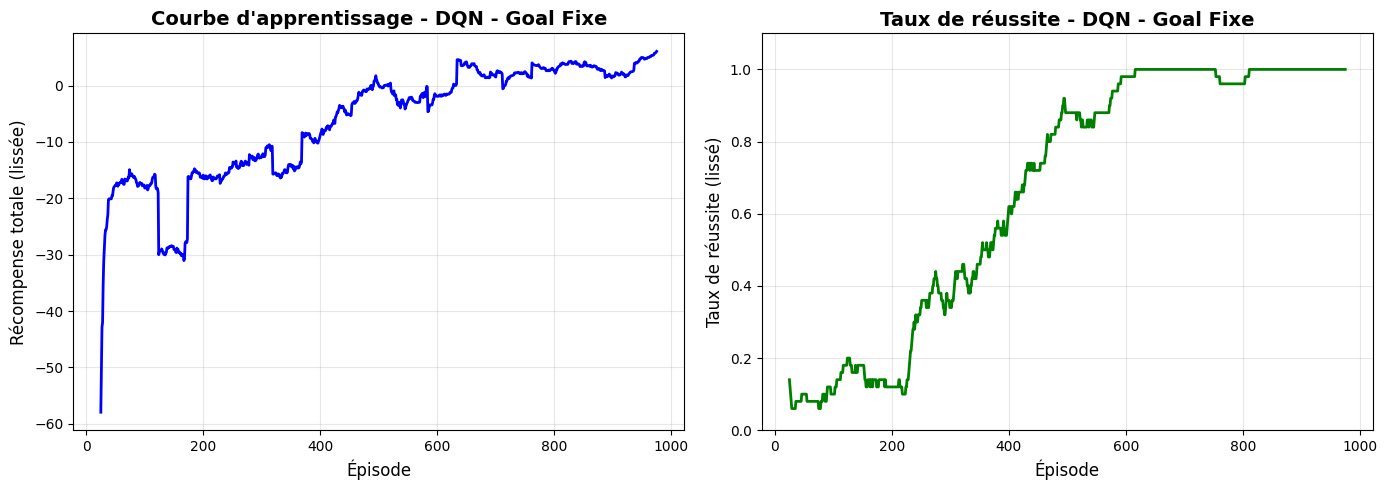

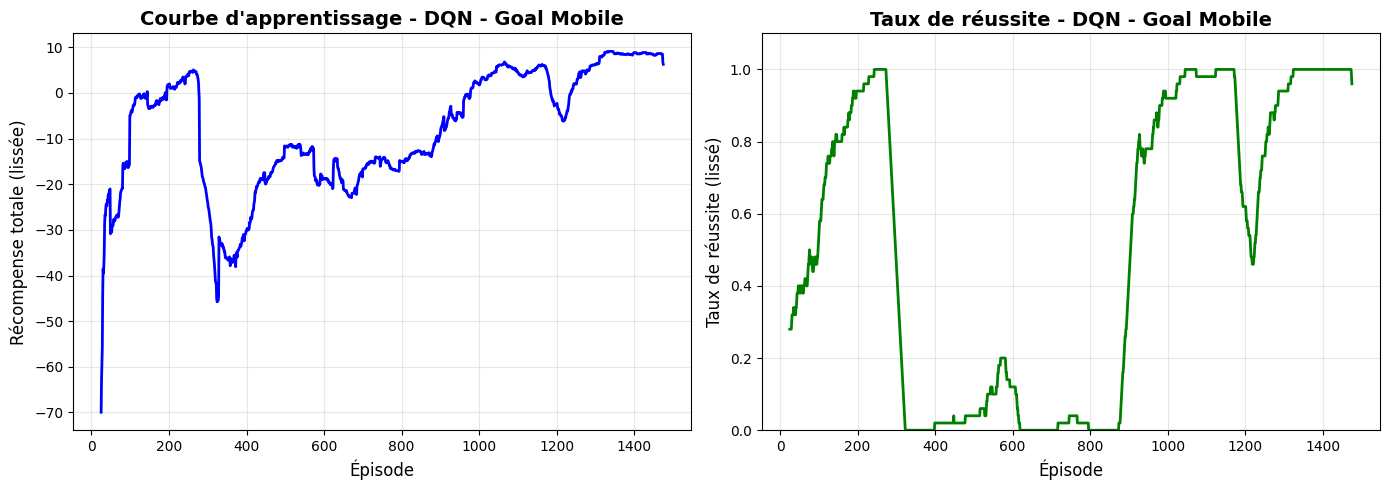

In [59]:
# Train DQN on the fixed goal environment
print("\n=== DQN: Environnement Stationnaire ===")
dqn_fixed, dqn_rewards_fixed, dqn_success_fixed = train_dqn(env_fixed, episodes=1000)

# Train DQN on the moving goal environment
print("\n=== DQN: Environnement Non-Stationnaire ===")
dqn_moving, dqn_rewards_moving, dqn_success_moving = train_dqn(env_moving, episodes=1500)

# Plot learning curves
plot_learning_curves(np.array(dqn_rewards_fixed), np.array(dqn_success_fixed), "DQN - Goal Fixe")
plot_learning_curves(np.array(dqn_rewards_moving), np.array(dqn_success_moving), "DQN - Goal Mobile")


DQN with stable-baselines

In [60]:
!pip install stable-baselines3[extra]

In [63]:
!pip install gymnasium

In [64]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class GridWorldSB3(gym.Env):
    """
    Stable-Baselines3-compatible wrapper for your GridWorld.
    """
    metadata = {"render_modes": ["human", "array"]}

    def __init__(self, grid_size=5, goal_moving=False):
        super(GridWorldSB3, self).__init__()

        self.grid_size = grid_size
        self.goal_moving = goal_moving

        self.agent_pos = [0, 0]
        self.goals = [[grid_size - 1, grid_size - 1]]
        self.step_count = 0

        # Gym-compatible spaces
        self.action_space = spaces.Discrete(4)  # 0=Up,1=Down,2=Left,3=Right
        self.observation_space = spaces.Box(
            low=0, high=grid_size - 1, shape=(2,), dtype=np.int32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = [0, 0]
        self.step_count = 0
        obs = np.array(self.agent_pos, dtype=np.int32)
        return obs, {}

    def step(self, action):
        self.step_count += 1

        # Movement
        if action == 0 and self.agent_pos[0] > 0:
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[0] < self.grid_size - 1:
            self.agent_pos[0] += 1
        elif action == 2 and self.agent_pos[1] > 0:
            self.agent_pos[1] -= 1
        elif action == 3 and self.agent_pos[1] < self.grid_size - 1:
            self.agent_pos[1] += 1

        # Reward
        reward = -1
        done = False
        if tuple(self.agent_pos) in [tuple(g) for g in self.goals]:
            reward = 10
            done = True

        # Move goal (non-stationary)
        if self.goal_moving and self.step_count % 10 == 0:
            self.goals[0] = [
                np.random.randint(0, self.grid_size),
                np.random.randint(0, self.grid_size)
            ]

        truncated = self.step_count >= 100
        obs = np.array(self.agent_pos, dtype=np.int32)
        info = {}

        return obs, reward, done, truncated, info

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), ".", dtype=str)
        for g in self.goals:
            grid[g[0], g[1]] = "G"
        grid[self.agent_pos[0], self.agent_pos[1]] = "A"
        print("\n".join(" ".join(row) for row in grid))
        print()

    def render_to_array(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        for g in self.goals:
            grid[g[0], g[1]] = 0.5
        grid[self.agent_pos[0], self.agent_pos[1]] = 1.0
        return grid

In [65]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

# Create environment
env_fixed = GridWorldSB3(grid_size=5, goal_moving=False)
env_moving = GridWorldSB3(grid_size=5, goal_moving=True)

# ✅ Validate environment (important!)
check_env(env_fixed, warn=True)

# Train DQN on stationary environment
model_fixed = DQN(
    policy="MlpPolicy",
    env=env_fixed,
    learning_rate=1e-3,
    buffer_size=10000,
    learning_starts=500,
    batch_size=64,
    gamma=0.95,
    train_freq=4,
    target_update_interval=500,
    exploration_fraction=0.3,
    exploration_final_eps=0.05,
    verbose=1,
)

print("\n=== Training DQN on Fixed Goal Environment ===")
model_fixed.learn(total_timesteps=50000)
model_fixed.save("dqn_gridworld_fixed")

# Train DQN on moving goal environment
model_moving = DQN(
    policy="MlpPolicy",
    env=env_moving,
    learning_rate=1e-3,
    buffer_size=10000,
    learning_starts=500,
    batch_size=64,
    gamma=0.95,
    train_freq=4,
    target_update_interval=500,
    exploration_fraction=0.3,
    exploration_final_eps=0.05,
    verbose=1,
)

print("\n=== Training DQN on Moving Goal Environment ===")
model_moving.learn(total_timesteps=75000)
model_moving.save("dqn_gridworld_moving")

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 3.85e-05 |
|    n_updates        | 18282    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05     |
|    ep_rew_mean      | 9.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 52604    |
|    fps              | 573      |
|    time_elapsed     | 128      |
|    total_timesteps  | 73636    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 5.42e-05 |
|    n_updates        | 18283    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05     |
|    ep_rew_mean      | 9.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 52608    |
|   

In [66]:
import time

env = env_fixed  # or env_moving
obs, _ = env.reset()
done = False
truncated = False

while not (done or truncated):
    action, _states = model_fixed.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    time.sleep(0.3)

. . . . .
A . . . .
. . . . .
. . . . .
. . . . G

. . . . .
. A . . .
. . . . .
. . . . .
. . . . G

. . . . .
. . A . .
. . . . .
. . . . .
. . . . G

. . . . .
. . . . .
. . A . .
. . . . .
. . . . G

. . . . .
. . . . .
. . . . .
. . A . .
. . . . G

. . . . .
. . . . .
. . . . .
. . . A .
. . . . G

. . . . .
. . . . .
. . . . .
. . . . .
. . . A G

. . . . .
. . . . .
. . . . .
. . . . .
. . . . A



In [67]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(model_fixed, env_fixed, n_eval_episodes=20)
print(f"Mean reward (fixed goal): {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(model_moving, env_moving, n_eval_episodes=20)
print(f"Mean reward (moving goal): {mean_reward:.2f} ± {std_reward:.2f}")

Mean reward (fixed goal): 3.00 ± 0.00
Mean reward (moving goal): 10.00 ± 0.00


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
